In [101]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import kendalltau

In [102]:
contaminacion = pd.read_csv("contaminacion_201710-201712.csv")
contaminacion['missing'] = pd.isnull(contaminacion.NO2)

contaminacion.sample(10)

,estacion,zona,timestamp,NO2,O3,PM10,PM25,missing
3769,Barajas Pueblo,3,2017-12-05 01:00:00,33.0,16.0,NaN,NaN,False
2021,Arturo Soria,3,2017-12-24 05:00:00,36.0,6.0,NaN,NaN,False
18874,Juan Carlos I,3,2017-11-20 10:00:00,70.0,16.0,NaN,NaN,False
24408,Pza. del Carmen,1,2017-10-05 23:00:00,63.0,24.0,NaN,NaN,False
11355,Ensanche de Vallecas,2,2017-10-14 02:00:00,98.0,3.0,NaN,NaN,False
15695,Farolillo,5,2017-10-10 22:00:00,114.0,1.0,41.0,NaN,False
3991,Barajas Pueblo,3,2017-12-14 07:00:00,64.0,2.0,NaN,NaN,False
1173,Arturo Soria,3,2017-11-18 21:00:00,89.0,1.0,NaN,NaN,False
30128,Villaverde Alto,5,2017-11-29 08:00:00,59.0,1.0,NaN,NaN,False
234,Arturo Soria,3,2017-10-10 17:00:00,65.0,71.0,NaN,NaN,False


### Ejemplo 1: media

In [103]:
contaminacion['NO2_fill1'] = contaminacion.NO2.where(pd.notna(contaminacion.NO2), contaminacion.NO2.mean())

contaminacion[pd.isna(contaminacion.NO2)].sample(5)

,estacion,zona,timestamp,NO2,O3,PM10,PM25,missing,NO2_fill1
4429,Barrio del Pilar,1,2017-10-01 12:00:00,NaN,66.0,NaN,NaN,True,55.007985
30154,Villaverde Alto,5,2017-11-30 10:00:00,NaN,17.0,NaN,NaN,True,55.007985
10073,El Pardo,4,2017-11-21 17:00:00,NaN,NaN,NaN,NaN,True,55.007985
11147,Ensanche de Vallecas,2,2017-10-05 10:00:00,NaN,NaN,NaN,NaN,True,55.007985
25500,Pza. del Carmen,1,2017-11-20 12:00:00,NaN,2.0,NaN,NaN,True,55.007985


Text(0.5,1,'Promedio NO2 por zona')

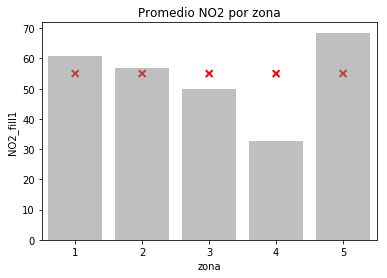

In [104]:
sns.barplot('zona', 'NO2', 
            data=contaminacion.groupby('zona')[['NO2']].mean().reset_index(),
            color='gray', alpha=0.5)

sns.pointplot('zona', 'NO2_fill1', 
              data=contaminacion[contaminacion.missing].groupby('zona')[['NO2_fill1']].min().reset_index(),
              color='red', linestyles="", markers="x")

plt.title("Promedio NO2 por zona")

### Ejemplo 2: media/mediana por estación

In [105]:
contaminacion['NO2_fill2'] = contaminacion.NO2.where(pd.notna(contaminacion.NO2), 
                                                     contaminacion.groupby('estacion').NO2.transform('mean'))
contaminacion[pd.isna(contaminacion.NO2)].sample(5)

,estacion,zona,timestamp,NO2,O3,PM10,PM25,missing,NO2_fill1,NO2_fill2
16898,Farolillo,5,2017-11-30 02:00:00,NaN,NaN,NaN,NaN,True,55.007985,56.990901
4443,Barrio del Pilar,1,2017-10-02 02:00:00,NaN,16.0,NaN,NaN,True,55.007985,62.602564
4440,Barrio del Pilar,1,2017-10-01 23:00:00,NaN,33.0,NaN,NaN,True,55.007985,62.602564
9369,El Pardo,4,2017-10-23 08:00:00,NaN,NaN,NaN,NaN,True,55.007985,25.867967
14797,Escuelas Aguirre,1,2017-12-04 13:00:00,NaN,NaN,11.0,8.0,True,55.007985,74.404178


Text(0.5,1,'Distribución NO2 por zona')

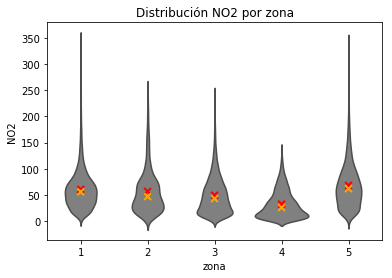

In [106]:
sns.violinplot('zona', 'NO2', data=contaminacion,
               inner=None, color='gray', alpha=0.5)

sns.pointplot('zona', 'NO2', 
              data=contaminacion.groupby('zona')[['NO2']].mean().reset_index(),
              color='red', linestyles="", markers="x")

sns.pointplot('zona', 'NO2', 
              data=contaminacion.groupby('zona')[['NO2']].median().reset_index(),
              color='orange', linestyles="", markers="x")

plt.title("Distribución NO2 por zona")

Text(0.5,1,'Distribución NO2 por estación (zona 4)')

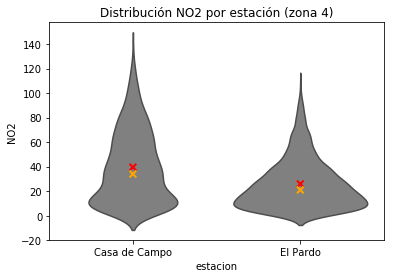

In [107]:
sns.violinplot('estacion', 'NO2', data=contaminacion[contaminacion.zona == 4],
               inner=None, color='gray', alpha=0.5)

sns.pointplot('estacion', 'NO2', 
              data=contaminacion[contaminacion.zona == 4].groupby('estacion')[['NO2']].mean().reset_index(),
              color='red', linestyles="", markers="x")

sns.pointplot('estacion', 'NO2', 
              data=contaminacion[contaminacion.zona == 4].groupby('estacion')[['NO2']].median().reset_index(),
              color='orange', linestyles="", markers="x")

plt.title("Distribución NO2 por estación (zona 4)")

### Ejemplo 3: imputación aleatoria por estación

In [108]:
def make_bins(values, binwidth):
    return np.floor(values / binwidth) * binwidth + (binwidth / 2)
    
contaminacion['NO2_bins'] = make_bins(contaminacion.NO2, 5)

In [111]:
NO2_sample = contaminacion.groupby('estacion').apply(
    lambda x: x[~x.missing].NO2_bins.sample(x.shape[0], replace=True)
).reset_index().NO2_bins

contaminacion['NO2_fill3'] = contaminacion.NO2.where(pd.notna(contaminacion.NO2), NO2_sample)

contaminacion[pd.isna(contaminacion.NO2)].sample(5)

,estacion,zona,timestamp,NO2,O3,PM10,PM25,missing,NO2_fill1,NO2_fill2,NO2_bins,NO2_fill3
4430,Barrio del Pilar,1,2017-10-01 13:00:00,NaN,67.0,NaN,NaN,True,55.007985,62.602564,NaN,37.5
4958,Barrio del Pilar,1,2017-10-23 13:00:00,NaN,58.0,NaN,NaN,True,55.007985,62.602564,NaN,117.5
14384,Escuelas Aguirre,1,2017-11-17 08:00:00,NaN,NaN,NaN,NaN,True,55.007985,74.404178,NaN,62.5
7792,Casa de Campo,4,2017-11-18 16:00:00,NaN,NaN,NaN,NaN,True,55.007985,39.528044,NaN,7.5
6827,Casa de Campo,4,2017-10-09 10:00:00,NaN,36.0,NaN,NaN,True,55.007985,39.528044,NaN,37.5


Text(0.5,1,'Distribución NO2 por estación (zona 4)')

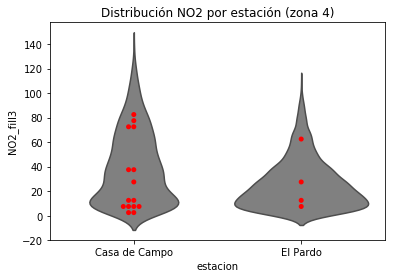

In [112]:
sns.violinplot('estacion', 'NO2', data=contaminacion[contaminacion.zona == 4],
               inner=None, color='gray', alpha=0.5)

sns.swarmplot('estacion', 'NO2_fill3', 
              data=contaminacion[(contaminacion.zona == 4) & (contaminacion.missing)],
              color='red')

plt.title("Distribución NO2 por estación (zona 4)")

### Ejemplo 4: imputación por regresión

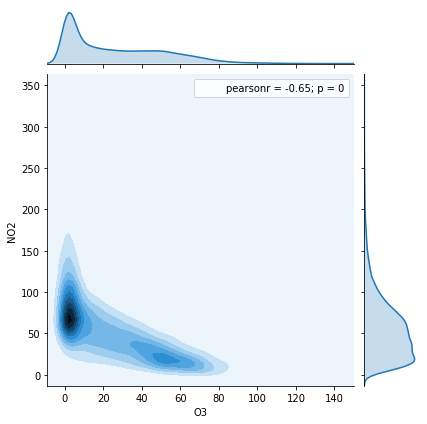

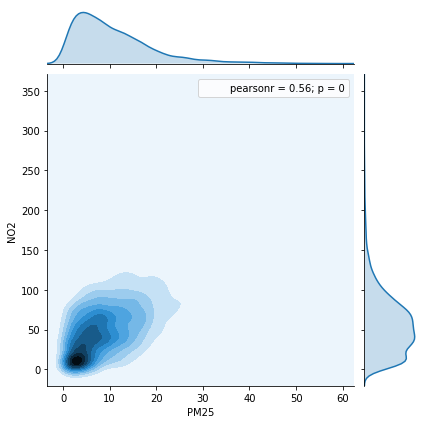

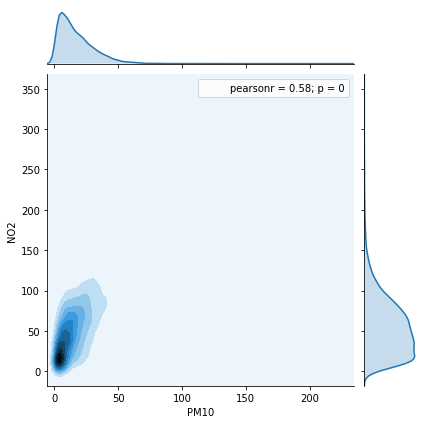

In [114]:
sns.jointplot('O3', 'NO2', data=contaminacion, kind='kde')
sns.jointplot('PM25', 'NO2', data=contaminacion, kind='kde')
sns.jointplot('PM10', 'NO2', data=contaminacion, kind='kde')

#### Regresión lineal

In [173]:
contaminacion['NO2_fill4'] = contaminacion.NO2

variables = contaminacion.dropna()

est_lineal = linear_model.LinearRegression()

In [174]:
for est in contaminacion.estacion.unique():
        
    variables_est = variables[variables.estacion == est]
    
    if len(variables_est) == 0:
        continue

    est_lineal.fit(variables_est[['O3', 'PM25', 'PM10']], variables_est.NO2)

    ind_pred = (contaminacion.estacion == est) & contaminacion.missing &\
               contaminacion.O3.notna() & contaminacion.PM25.notna() & contaminacion.PM10.notna()
    
    if sum(ind_pred) == 0:
        continue

    contaminacion.loc[ind_pred, 'NO2_fill4'] = est_lineal.predict(contaminacion.loc[ind_pred, ['O3', 'PM25', 'PM10']])

In [175]:
contaminacion[contaminacion.missing & contaminacion.NO2_fill4.notna()]

,estacion,zona,timestamp,NO2,O3,PM10,PM25,missing,NO2_fill1,NO2_fill2,NO2_bins,NO2_fill3,NO2_fill4
6682,Casa de Campo,4,2017-10-03 09:00:00,NaN,1.0,19.0,8.0,True,55.007985,39.528044,NaN,2.5,61.096838
7858,Casa de Campo,4,2017-11-21 10:00:00,NaN,7.0,33.0,20.0,True,55.007985,39.528044,NaN,12.5,68.148112
8196,Casa de Campo,4,2017-12-05 12:00:00,NaN,16.0,29.0,18.0,True,55.007985,39.528044,NaN,82.5,58.674243


Text(0.5,1,'Niveles de NO2 en Casa de Campo')

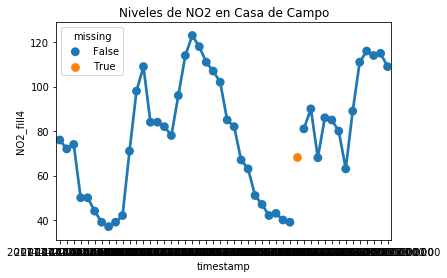

In [218]:
sns.pointplot('timestamp', 'NO2_fill4', hue='missing', 
              data=contaminacion[(contaminacion.estacion == "Casa de Campo") &\
                                 (contaminacion.timestamp >= "2017-11-20") &\
                                 (contaminacion.timestamp < "2017-11-22")])

plt.title("Niveles de NO2 en Casa de Campo")

Text(0.5,1,'Niveles de NO2 en Casa de Campo')

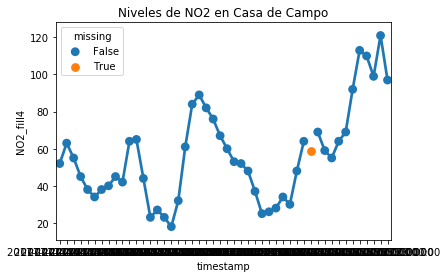

In [219]:
sns.pointplot('timestamp', 'NO2_fill4', hue='missing', 
              data=contaminacion[(contaminacion.estacion == "Casa de Campo") &\
                                 (contaminacion.timestamp >= "2017-12-04") &\
                                 (contaminacion.timestamp < "2017-12-06")])

plt.title("Niveles de NO2 en Casa de Campo")

#### Árbol de decisión

### Ejemplo 5: imputación temporal con última observación